<a href="https://colab.research.google.com/github/RodrickGulu/Final_Year_Project/blob/main/training_model_with_blurry_image_filter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Class count before oversampling: [ 516 1083]


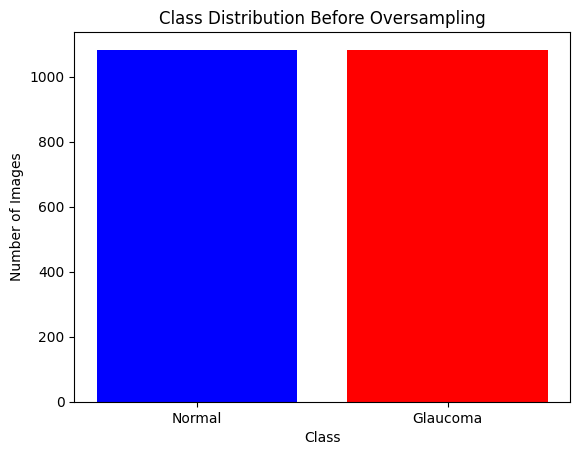

Class count after oversampling: [1083 1083]


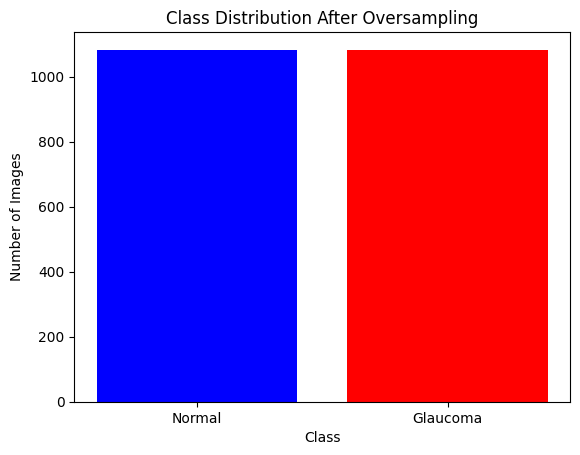

80134624/80134624 [==============================] - 0s 0us/step


Epoch 1/20
44/44 [==============================] - ETA: 0s - loss: 0.4831 - accuracy: 0.9567
Epoch 1: val_accuracy improved from -inf to 0.98157, saving model to vgg19_glaucoma.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


44/44 [==============================] - 28s 348ms/step - loss: 0.4831 - accuracy: 0.9567 - val_loss: 0.7184 - val_accuracy: 0.9816
Epoch 2/20
44/44 [==============================] - ETA: 0s - loss: 0.0995 - accuracy: 0.9942
Epoch 2: val_accuracy did not improve from 0.98157
44/44 [==============================] - 10s 215ms/step - loss: 0.0995 - accuracy: 0.9942 - val_loss: 0.1864 - val_accuracy: 0.9724
Epoch 3/20
44/44 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.9948
Epoch 3: val_accuracy did not improve from 0.98157
44/44 [==============================] - 9s 212ms/step - loss: 0.0808 - accuracy: 0.9948 - val_loss: 0.1724 - val_accuracy: 0.9816
Epoch 4/20
44/44 [==============================] - ETA: 0s - loss: 0.1028 - accuracy: 0.9936
Epoch 4: val_accuracy improved from 0.98157 to 0.98618, saving model to vgg19_glaucoma.h5
44/44 [==============================] - 10s 219ms/step - loss: 0.1028 - accuracy: 0.9936 - val_loss: 0.6046 - val_accuracy: 0.9862

In [ ]:

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def load_images_from_folder(folder_path):
    images = []
    labels = []

    for folder_name in os.listdir(folder_path):
        folder = os.path.join(folder_path, folder_name)
        if not os.path.isdir(folder):
            continue

        label = 1 if folder_name == "glaucoma" else 0

        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)

            # Check if img is not None before processing
            if img is not None:
                img = cv2.resize(img, (224, 224))
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                blur = cv2.Laplacian(gray, cv2.CV_64F).var()

                # Set a threshold for blur
                if blur > 100:
                    images.append(img)
                    labels.append(label)

    return np.array(images), np.array(labels)

# Load images from the folder
dataset_path = '/content/drive/MyDrive/glaucoma_dataset/training'
images, labels = load_images_from_folder(dataset_path)

# Count the number of images in each class before oversampling
class_counts_before_oversampling = np.bincount(labels)
print(f"Class count before oversampling: {class_counts_before_oversampling}")
class_names = ["Normal", "Glaucoma"]

# Plot bar chart for class distribution before oversampling
plt.bar(class_names, class_counts_before_oversampling[1:], color=['blue', 'red'])
plt.title('Class Distribution Before Oversampling')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

# Apply oversampling using SMOTE
oversample = SMOTE(sampling_strategy='auto', random_state=42)
x_resampled, y_resampled = oversample.fit_resample(images.reshape(-1, 224 * 224 * 3), labels)

# Reshape back to image format
x_resampled = x_resampled.reshape(-1, 224, 224, 3)

# Count the number of images in each class after oversampling
class_counts_after_oversampling = np.bincount(y_resampled)
print(f"Class count after oversampling: {class_counts_after_oversampling}")
class_names = ["Normal", "Glaucoma"]

# Plot bar chart for class distribution after oversampling
plt.bar(class_names, class_counts_after_oversampling[1:], color=['blue', 'red'])
plt.title('Class Distribution After Oversampling')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

# Split the data into training, validation, and testing sets
x_train, x_temp, y_train, y_temp = train_test_split(x_resampled, y_resampled, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Model architecture
def create_model():
    vgg = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    for layer in vgg.layers:
        layer.trainable = False

    model = Sequential()
    model.add(vgg)
    model.add(Flatten())
    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Create a single model
model = create_model()

# Model callbacks
callbacks_list = [ModelCheckpoint("/content/drive/MyDrive/best_model_vgg19_glaucoma.h5", monitor="val_accuracy", verbose=1, save_best_only=True, save_weights_only=False, period=1),
                  EarlyStopping(monitor="val_accuracy", patience=10, verbose=1)]

# Train the model
history = model.fit(x_train, y_train, batch_size=40, epochs=20, validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

# Evaluate the model on the test set
predictions = model.predict(x_test)
predictions_binary = (predictions > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions_binary)
print("Model Accuracy Score on Test Set:", accuracy)

Classification Report for VGG19 Predictions:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       119
           1       0.99      0.98      0.98        98

    accuracy                           0.99       217
   macro avg       0.99      0.99      0.99       217
weighted avg       0.99      0.99      0.99       217

Confusion Matrix for Ensemble Predictions:
 [[118   1]
 [  2  96]]


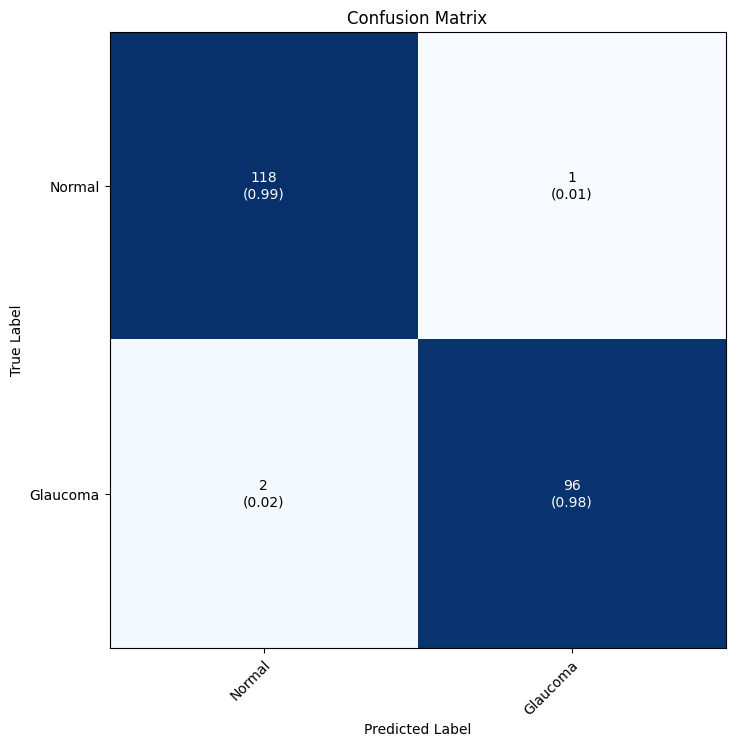

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt

# Evaluate the ensemble
ensemble_classification_report = classification_report(y_test, predictions_binary)
print("Classification Report for VGG19 Predictions:\n", ensemble_classification_report)

# Compute the confusion matrix for ensemble predictions
cm = confusion_matrix(y_test, predictions_binary)
print("Confusion Matrix for Ensemble Predictions:\n", cm)

# Plot the confusion matrix
plot_confusion_matrix(conf_mat=cm, figsize=(8, 8), class_names=["Normal", "Glaucoma"], show_normed=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

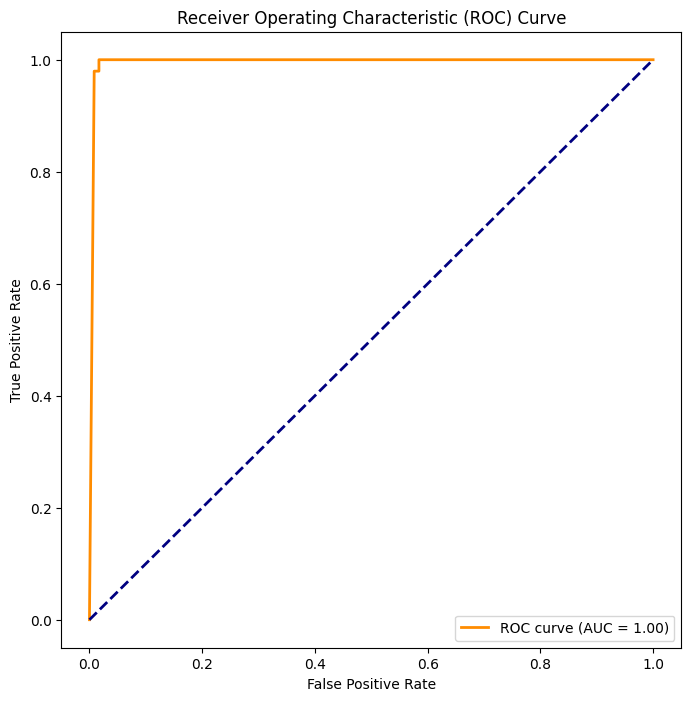

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_probs):
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(y_test, predictions)